In [ ]:
pip install -U classiq

In [ ]:
import classiq
classiq.authenticate()

# Quantum Walk
1. Vertex: Each node of a graph is represented by a node.
2. Edges: Vertices are connected via the edges. This connection can be either directed or undirected depending on the graph.

In this problem we have to traverse the following graph:
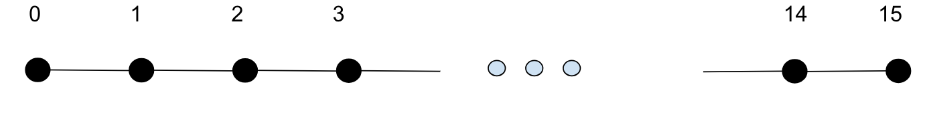

This entire method constists of 2 parts:
1. Encoding the graph nodes into quantum states.
2. Evolving the quantum state as per the edges in the graph.

In [ ]:
from classiq import *

size = 4

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

### Step - 1:
In this step, we will encode the nodes in quantum states.
This is done, on a higher level, using the following formula:
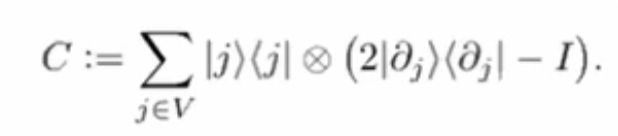

On careful observations, we see that the above formula can be transformed to a simple phase-kickback form.

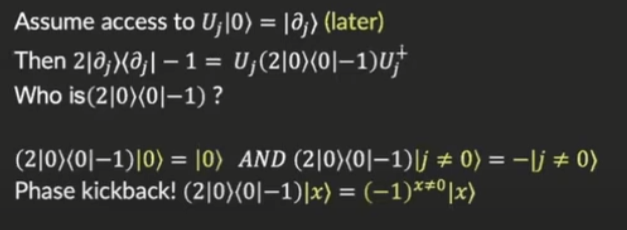



The above code prepares the state using the unitary transformation : 2*|0><0| - 1.

The following code block encodes the nodes in the graph into a quantum state.

In [ ]:
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0] * 16
    if i == 0:
        prob[1] = 1.0
    elif i == 15:
        prob[14] = 1.0
    else:
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5
    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)

### Note:
We have created the desired state δ, which is an equal superpositon of 2 adjacent nodes.

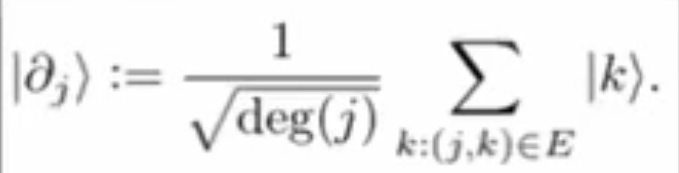



This ends the encoding part. Now, we need to evolve the system to complete the traversal. For this, the following formula is being used (ref. - Ch-17:A Discreete-Time Quantum Walk, Lecture Notes on Quantum Algorithms).
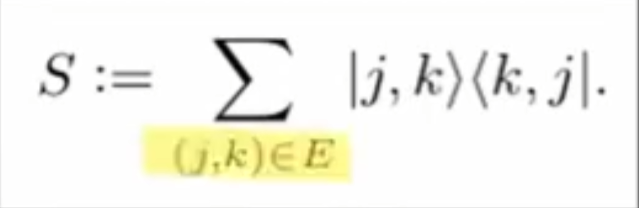

For this specific graph, the result(whether edge is present between |k> and |j> vertices or not) can be obtained if
  1. vertex + adjacent_vertex = odd : 1
  2. vertex + adjacent_vertex = even : 0

In [ ]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))


@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

Finally the main function, we declare the vertices and the graph that has to be traversed. Before running the algorithm, we create an equal superposition of all the vertices.

In [ ]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

On running the program on Classiq's Quantum Simulator, we get the following circuit:

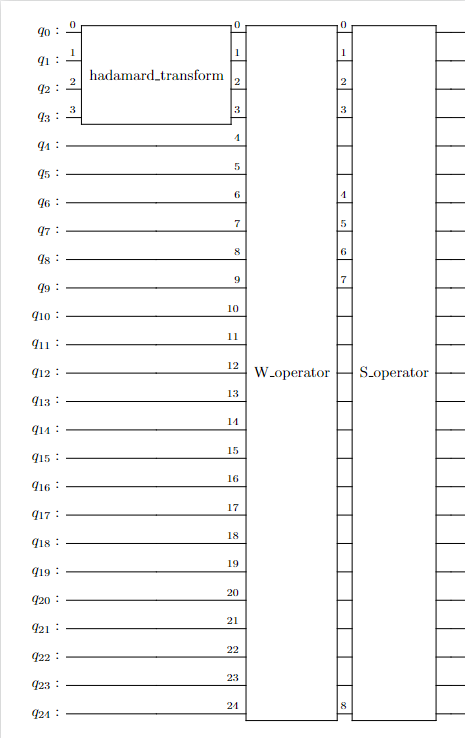

The final graph plotted after execution:

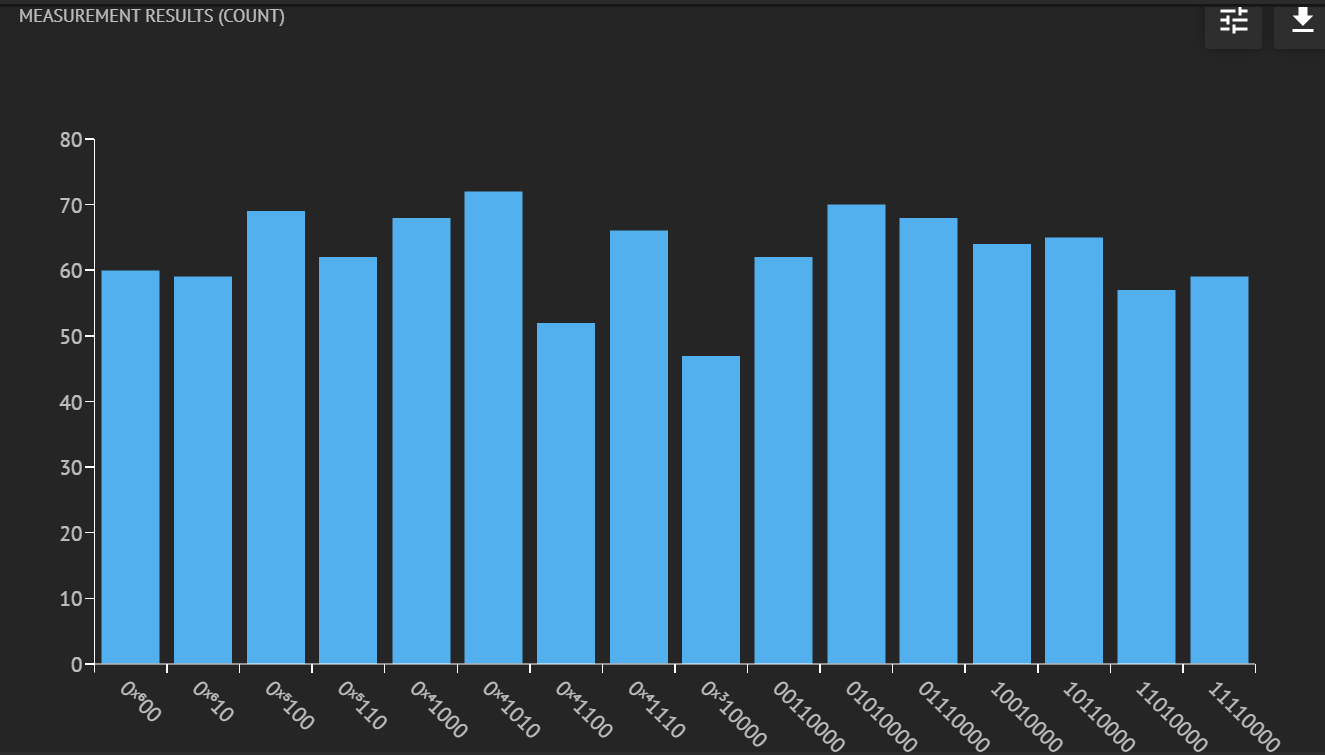